In [18]:
import pprint
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Comparison of Bayesian Optimization Frameworks | Baselines

In this notebook we are going to create baseline models to later compare with models which used bayesian optimization techniques for parameter tuning.

## Global Settings

In [19]:
RANDOM_SEED = 42
DATASET_FOLDER = '../datasets/mobile_price_classification'

In [20]:
train = pd.read_csv(f'{DATASET_FOLDER}/train.csv')
test = pd.read_csv(f'{DATASET_FOLDER}/test.csv')
print(f"""
Shapes
======
    train: {train.shape}
    test : {test.shape}      
""")
train.head(3)


Shapes
    train: (2000, 21)
    test : (1000, 21)      



,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2


In [21]:
TARGET = 'price_range'
FEATURES = list(set(train.columns).difference({TARGET}))

In [22]:

def predict_and_summarize(X_train_scaled,
                          X_test_scaled, 
                          y_train, 
                          y_test,
                          clf,
                          model_type):

    y_pred_train = clf.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, y_pred_train)
    train_prec = precision_score(y_train, y_pred_train, average='macro', zero_division=0)
    train_rec = recall_score(y_train, y_pred_train, average='macro', zero_division=0)
    train_f1 = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

    y_pred = clf.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    test_rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"""
    Performance Results : {model_type} 
    ========================================
                    {'Train':<10}{'Test':<10}
        Accuracy  : {train_acc:<10.4f}{test_acc:<10.4f}
        Precision : {train_prec:<10.4f}{test_prec:<10.4f}
        Recall    : {train_rec:<10.4f}{test_rec:<10.4f}
        F1-Score  : {train_f1:<10.4f}{test_f1:<10.4f}
    """)

    return {'y_pred_train': y_pred_train, 'y_pred_test': y_pred}

## Dataset Preparation

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train[FEATURES],
                                                    train[TARGET], 
                                                    test_size=0.3, 
                                                    random_state=RANDOM_SEED,
                                                    stratify=train[TARGET])

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Baseline Models

Let's train a small baseline model to get a feeling for how much better the bayesian optimizated models will get.

### LogisticRegression

In [25]:
lrc = LogisticRegression()

lrc.fit(X_train_scaled, y_train)

y_preds = predict_and_summarize(X_train_scaled,
                                X_test_scaled, 
                                y_train, 
                                y_test,
                                lrc,
                                'LogisticRegression')


    Performance Results : LogisticRegression 
                    Train     Test      
        Accuracy  : 0.9764    0.9600    
        Precision : 0.9765    0.9603    
        Recall    : 0.9764    0.9600    
        F1-Score  : 0.9764    0.9600    
    


FileNotFoundError: [Errno 2] No such file or directory: 'imgs/lr_cm_untuned.png'

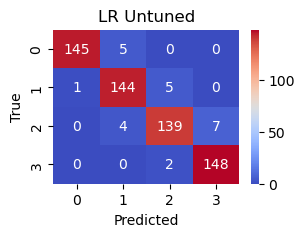

In [26]:
cm = confusion_matrix(y_test, y_preds.get('y_pred_test'))
class_labels = np.unique(y_test)

plt.figure(figsize=(3, 2))
sns.heatmap(cm, 
            annot=True, 
            cmap='coolwarm', 
            fmt='d', 
            xticklabels=class_labels, 
            yticklabels=class_labels,
            cbar_kws={'ticks': [0, 50, 100, 150]})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LR Untuned')

plt.savefig('../imgs/lr_cm_untuned.png', dpi=300, bbox_inches='tight')

plt.show()

The model is already strongly predictive. However, let's see if we can improve performance by tuning hyperparameters of a model.

### RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(random_state=RANDOM_SEED)

rfc.fit(X_train_scaled, y_train)

y_preds = predict_and_summarize(X_train_scaled,
                                X_test_scaled, 
                                y_train, 
                                y_test,
                                rfc,
                                'RandomForestClassifier')


    Performance Results : RandomForestClassifier 
                    Train     Test      
        Accuracy  : 1.0000    0.8683    
        Precision : 1.0000    0.8672    
        Recall    : 1.0000    0.8683    
        F1-Score  : 1.0000    0.8675    
    


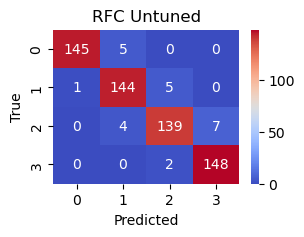

In [27]:
cm = confusion_matrix(y_test, y_preds.get('y_pred_test'))
class_labels = np.unique(y_test)

plt.figure(figsize=(3, 2))
sns.heatmap(cm, 
            annot=True, 
            cmap='coolwarm', 
            fmt='d', 
            xticklabels=class_labels, 
            yticklabels=class_labels,
            cbar_kws={'ticks': [0, 50, 100, 150]})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RFC Untuned')

plt.savefig('../imgs/rfc_cm_untuned.png', dpi=300, bbox_inches='tight')

plt.show()

The un-tuned random forest classifier is highly overfit and the test performance is lower then the one from the logistic regression.